In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import h5py

## Task 1: CNNs for Galaxy Classification

In [2]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5",
    "data/Galaxy10.h5"
)

In [21]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

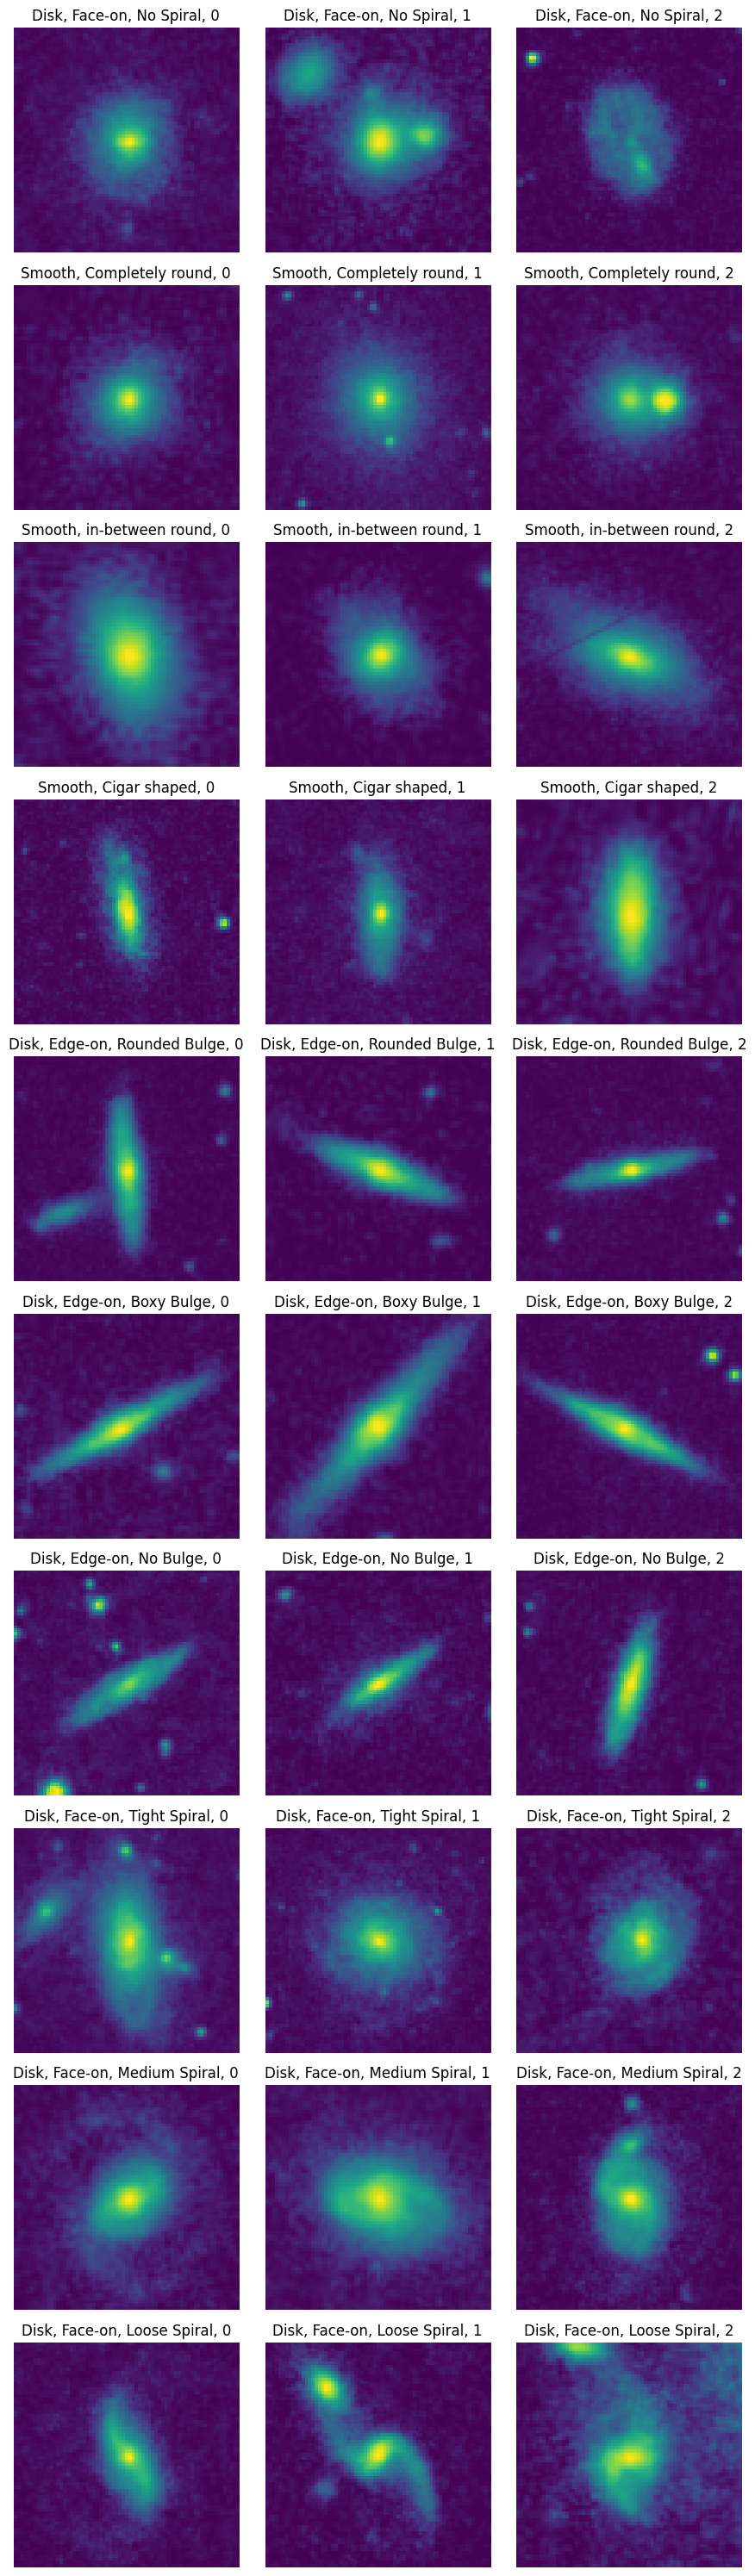

In [4]:
# TODO: plot three samples of each class

images_numpy = images.numpy()
labels_numpy = labels.numpy()

n_instances = 3

# Create a figure for all subplots
fig, axes = plt.subplots(n_classes, n_instances, figsize=(n_instances * 3, n_classes * 3))

# Loop through classes and instances
for i in range(n_classes):
    images_class = images_numpy[labels_numpy == i]
    for j in range(n_instances):
        ax = axes[i, j] if n_classes > 1 else axes[j]  # Adjust indexing for 1-row case
        ax.imshow(images_class[j][0])
        ax.set_title(f"{label_names[i]}, {j}")
        ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
from torchvision.transforms import Normalize

mean = images_numpy.mean(axis=(0, 2, 3))
std = images_numpy.std(axis=(0, 2, 3))

print(f'Mean for each color channel:{mean}, Std for each color channel:{std}')
normalize = Normalize(mean=mean.tolist(), std=std.tolist())

images = normalize(images)

# TODO: Split the data and normalize the images:
n_train = int(0.8 * len(images))
n_val = int(0.1 * len(images))
n_test = len(images) - n_train - n_val

# Split the dataset into Subsets
train_indices, val_indices, test_indices = torch.utils.data.random_split(range(len(images)), [n_train, n_val, n_test])


# Extract images and labels for each split
images_train = images[train_indices.indices]
images_validation = images[val_indices.indices]
images_test = images[test_indices.indices]

labels_train = labels[train_indices.indices]
labels_validation = labels[val_indices.indices]
labels_test = labels[test_indices.indices]

# Create TensorDatasets for each split
train_dataset = TensorDataset(images_train, labels_train)
val_dataset = TensorDataset(images_validation, labels_validation)
test_dataset = TensorDataset(images_test, labels_test)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Mean for each color channel:[20.5449   16.959858 13.120861], Std for each color channel:[35.43675  29.822596 24.93109 ]
tensor([0, 1, 1,  ..., 0, 4, 8], dtype=torch.uint8)
Train size: 17428, Validation size: 2178, Test size: 2179


### (b)

In [25]:
#TODO: implement a small CNN as specified on the sheet
from torch import nn

class GalaxyCNN(nn.Module): 
    def __init__(self):
        super(GalaxyCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Placeholder for flattened size; will be calculated dynamically
        self.flattened_size = None

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Dynamically calculate the flattened size if not set
        if self.flattened_size is None:
            self.flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flattened_size, 64)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch size
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x


###

### (c) + (d) + (e)

accuracy=0.31, avg_loss=1.77e+00
Epoch 1/60, Train Loss: 1.8042, Val Loss: 1.7710, Val Acc: 0.3150
Model saved with validation loss: 1.7710
accuracy=0.29, avg_loss=1.78e+00
Epoch 2/60, Train Loss: 1.7524, Val Loss: 1.7781, Val Acc: 0.2883
accuracy=0.35, avg_loss=1.74e+00
Epoch 3/60, Train Loss: 1.7396, Val Loss: 1.7426, Val Acc: 0.3508
Model saved with validation loss: 1.7426
accuracy=0.34, avg_loss=1.69e+00
Epoch 4/60, Train Loss: 1.7052, Val Loss: 1.6949, Val Acc: 0.3398
Model saved with validation loss: 1.6949
accuracy=0.36, avg_loss=1.67e+00
Epoch 5/60, Train Loss: 1.6747, Val Loss: 1.6680, Val Acc: 0.3590
Model saved with validation loss: 1.6680
accuracy=0.37, avg_loss=1.65e+00
Epoch 6/60, Train Loss: 1.6596, Val Loss: 1.6466, Val Acc: 0.3659
Model saved with validation loss: 1.6466
accuracy=0.36, avg_loss=1.64e+00
Epoch 7/60, Train Loss: 1.6428, Val Loss: 1.6434, Val Acc: 0.3590
Model saved with validation loss: 1.6434
accuracy=0.34, avg_loss=1.68e+00
Epoch 8/60, Train Loss: 1.63

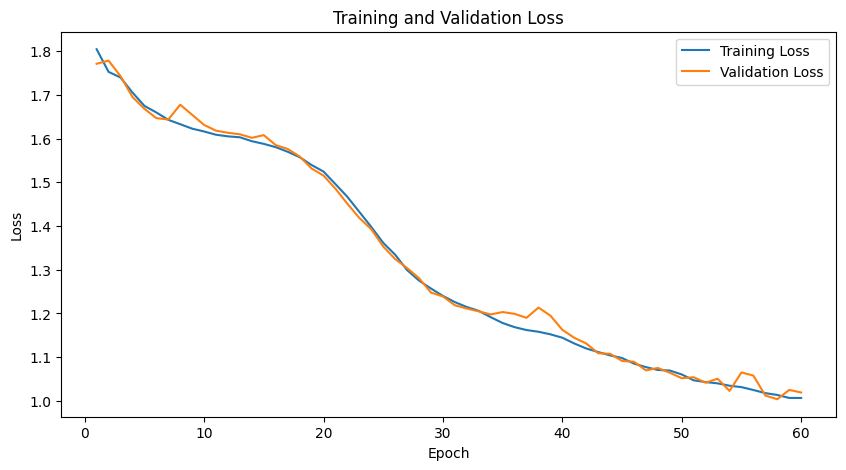

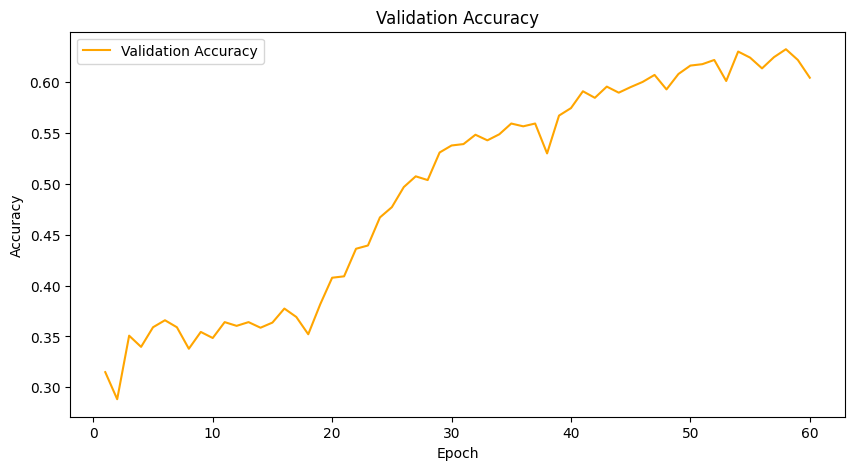

In [32]:
# TODO: Instantiate the model, optimizer and criterion
model = GalaxyCNN()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
"""For a classification task, we suggest CrossEntropyLoss as a loss function,
as it combines LogSoftmax and NLLLoss in one single step and is well-suited for multi-class classification problems."""

train_losses = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.
    
def validate(model, val_loader, criterion):
    model.eval()
    losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_loss = np.mean(losses)
    accuracy = correct / total
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')
    return avg_loss, accuracy

# Training loop
def train(model, train_loader, val_loader, optimizer, criterion, epochs=30, save_path="best_model.pth"):
    best_val_loss = float("inf")  # Initialize best validation loss
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        

        # Validate the model after each epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the model if the validation loss is the lowest encountered
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with validation loss: {val_loss:.4f}")

    print("Training complete. Best validation loss:", best_val_loss)


num_epochs = 60
train(model, train_loader, val_loader, optimizer, criterion, epochs=num_epochs)

# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

### (e) continued

C:\Users\roger\AppData\Local\Temp\ipykernel_11744\2780051891.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Test Loss: 1.0415


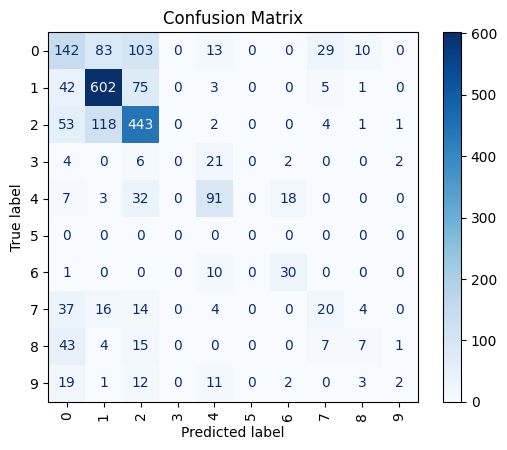

In [33]:
# TODO: Evaluate the best validation model on the test set and create a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_on_test(model, test_loader, criterion, save_path="best_model.pth"):
    # Load the best model
    model.load_state_dict(torch.load(save_path))
    model.eval()

    all_preds = []
    all_targets = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Collect predictions and targets
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_preds, labels=range(len(label_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(label_names)))
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()
    
evaluate_on_test(model, test_loader, criterion, save_path="best_model.pth")


In [34]:
from torchvision.transforms import Compose, RandomRotation

# Define a data augmentation pipeline with rotations
transform = Compose([
    RandomRotation(degrees=[0, 90, 180, 270]),  # Randomly rotate by multiples of 90°
    transforms.ToTensor(),
    transforms.Normalize(mean, std),           # Normalize with the dataset's mean and std
])

# Apply the transform to your dataset
train_dataset = datasets.TensorDataset(images_train, labels_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

def test_time_augmentation(model, test_loader, device):
    rotations = [0, 90, 180, 270]
    all_predictions = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = []

        for angle in rotations:
            # Rotate the inputs by the given angle
            rotated_inputs = transforms.functional.rotate(inputs, angle)
            
            # Get predictions from the model
            outputs = model(rotated_inputs)
            predictions.append(outputs)

        # Average predictions across rotations
        avg_predictions = torch.mean(torch.stack(predictions), dim=0)
        all_predictions.append(avg_predictions)

    return torch.cat(all_predictions)

from e2cnn import gspaces, nn

# Define the group of rotations
r2_act = gspaces.Rot2dOnR2(N=8)  # Rotation group with 8 discrete orientations

# Create an equivariant convolutional layer
equiv_layer = nn.R2Conv(
    in_type=r2_act.trivial_repr,
    out_type=r2_act.regular_repr,
    kernel_size=5,
    padding=2,
    bias=True
)

def rotation_invariant_pooling(model, inputs, rotations=[0, 90, 180, 270]):
    features = []

    for angle in rotations:
        rotated_inputs = transforms.functional.rotate(inputs, angle)
        features.append(model(rotated_inputs))

    # Apply max or average pooling over the features
    invariant_features = torch.max(torch.stack(features), dim=0).values
    return invariant_features


ValueError: degrees should be a sequence of length 2.

## 3 Positional Encoding

$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $